### [Build a linear model with Estimators](https://www.tensorflow.org/beta/tutorials/estimators/linear)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from __future__ import absolute_import, print_function, division, unicode_literals

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

#### Load the dataset

In [4]:
X_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
X_test = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = X_train.pop('survived')
y_test = X_test.pop('survived')

A little insight on our data!

In [5]:
X_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
X_train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
X_train.shape[0], X_test.shape[0]

(627, 264)

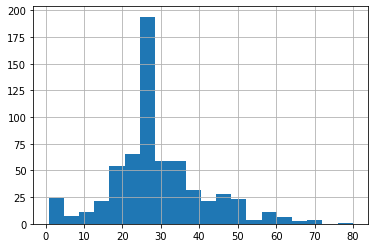

In [8]:
X_train.age.hist(bins=20);

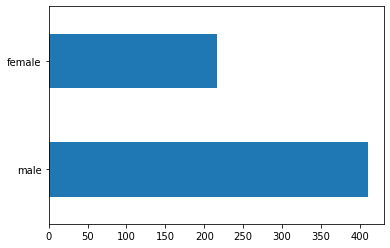

In [9]:
X_train.sex.value_counts().plot(kind='barh');

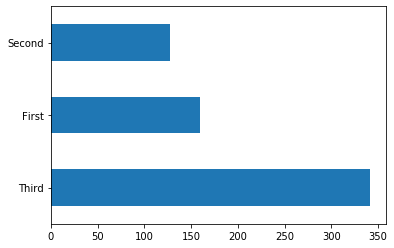

In [10]:
X_train['class'].value_counts().plot(kind='barh');

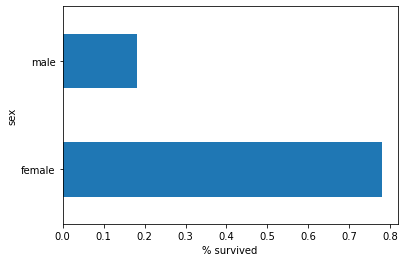

In [11]:
pd.concat([X_train, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived');

#### Feature columns

In [12]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [13]:
feature_columns = []

In [14]:
for feature_name in CATEGORICAL_COLUMNS:
    vocab = X_train[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [15]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_fn():
        df = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            df = df.shuffle(1000)
        df = df.batch(batch_size).repeat(num_epochs)
        return df
    return input_fn

In [16]:
train_input_fn = make_input_fn(X_train, y_train)
test_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

A small example!

In [17]:
df = make_input_fn(X_train, y_train, batch_size=10)()

In [18]:
for feature_batch, label_batch in df.take(1):
    print('Feature keys: {}'.format(feature_batch.keys()))
    print('Class batch: {}'.format(feature_batch['class'].numpy()))
    print('Labels batch: {}'.format(label_batch.numpy()))

Feature keys: dict_keys(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone'])
Class batch: [b'First' b'Third' b'Third' b'Second' b'Third' b'Third' b'Second' b'Third'
 b'Third' b'Third']
Labels batch: [0 0 1 1 0 0 1 0 0 1]


#### Training

In [19]:
clf = tf.estimator.LinearClassifier(feature_columns=feature_columns)
clf.train(train_input_fn)

In [20]:
result = clf.evaluate(test_input_fn)

In [21]:
print(result['accuracy'])

0.7689394


#### Derived feature column

In [22]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [23]:
clf = tf.estimator.LinearClassifier(feature_columns=feature_columns+[age_x_gender])
clf.train(train_input_fn)

In [24]:
result = clf.evaluate(test_input_fn)

In [25]:
print(result['accuracy'])

0.75757575


#### Make predictions

In [26]:
pred_dicts = list(clf.predict(test_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

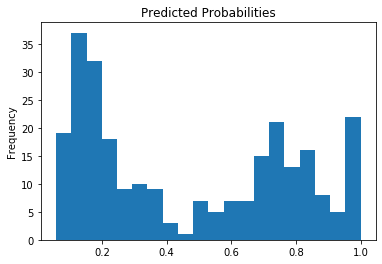

In [27]:
probs.plot(kind='hist', bins=20, title='Predicted Probabilities');

#### Receiver Operating Characteristic (ROC)

In [28]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

(0, 1.05)

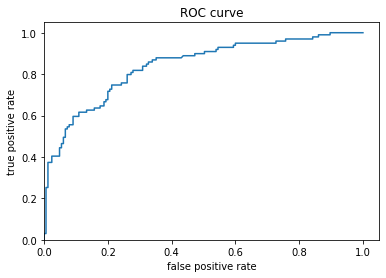

In [29]:
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)